picked label: 7 raw index: 34


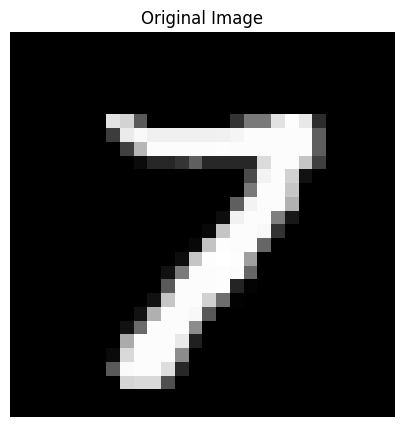

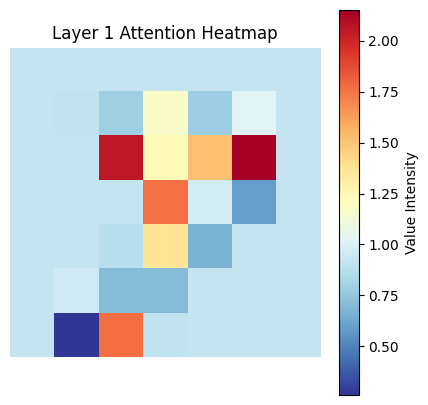

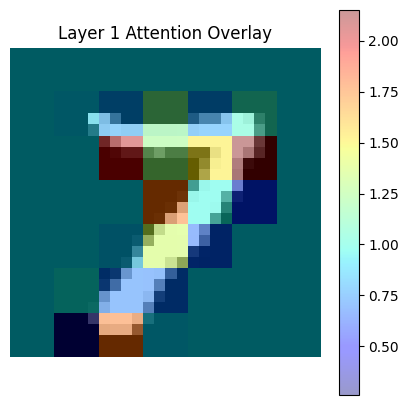

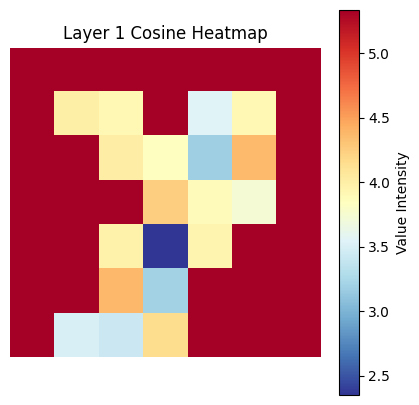

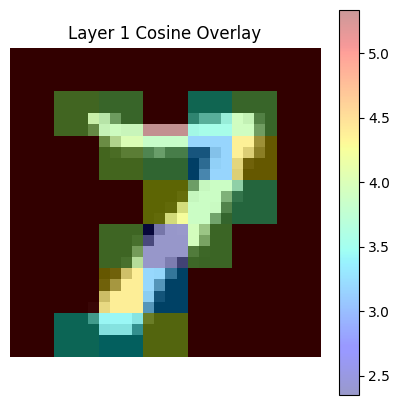

In [5]:
# One-cell runner: configure model + dataset, then show layerwise attention/cosine heatmaps (no saving)
import os
import sys
import importlib
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# ---- Config ----
PROJECT_ROOT = "/home/junyeollee/QSANN/codes/QSANN_revision"
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

MODEL_MODULE = "model"  # or 'model_revision'
CHECKPOINT_PATH = "/home/junyeollee/QSANN/codes/QSANN_revision/results/models/mnist[1-7]-n600-N1200-20251226-093646_best.pt"

DATASET_CHOICE = "mnist"  # 'mnist' | 'fmnist' | 'cifar10'
DATA_ROOT = "/home/junyeollee/QSANN/codes/QSANN_revision/data"
TARGET_LABELS = [1, 7]  # only pick from these classes
SAMPLE_INDEX = 8  # index within the filtered subset

IMAGE_SIZE = 28
PATCH_SIZE = 4
NUM_QUBITS = 8
VQC_LAYERS = 1
REUPLOADING = 2
MEASUREMENT = "correlations"  # or 'statevector'
BACKEND_DEVICE = "gpu"  # or 'cpu'
USE_TORCH_AUTOGRAD = True

QKV_MODE = "separate"  # 'shared' or 'separate'
QKV_DIM = 64
ATTN_LAYERS = 1
ATTN_TYPE = "rbf"  # 'dot' or 'rbf'
RBF_GAMMA = 1.0
AGG_MODE = "concat"  # 'concat' | 'gap_gmp' | 'attn_pool'
HIDDEN_DIMS = []  # e.g., [64], or [] for none
DROPOUT = 0.3
NUM_CLASSES = 1

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

# ---- Load sample ----
if DATASET_CHOICE in ("mnist", "fmnist"):
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
    ])
    if DATASET_CHOICE == "mnist":
        ds = datasets.MNIST(root=DATA_ROOT, train=False, download=False, transform=transform)
    else:
        ds = datasets.FashionMNIST(root=DATA_ROOT, train=False, download=False, transform=transform)
    labels = [int(y) for _, y in ds]
    indices = [i for i, y in enumerate(labels) if y in TARGET_LABELS]
    if not indices:
        raise RuntimeError("No samples found for TARGET_LABELS.")
    idx = indices[SAMPLE_INDEX % len(indices)]
    img, label = ds[idx]
    sample_tensor = img.unsqueeze(0)  # [1, 1, H, W]
    print("picked label:", label, "raw index:", idx)
elif DATASET_CHOICE == "cifar10":
    CIFAR_GRAYSCALE = False  # set True to match grayscale training
    if CIFAR_GRAYSCALE:
        transform = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor(),
        ])
    ds = datasets.CIFAR10(root=DATA_ROOT, train=False, download=False, transform=transform)
    labels = [int(y) for _, y in ds]
    indices = [i for i, y in enumerate(labels) if y in TARGET_LABELS]
    if not indices:
        raise RuntimeError("No samples found for TARGET_LABELS.")
    idx = indices[SAMPLE_INDEX % len(indices)]
    img, label = ds[idx]
    sample_tensor = img.unsqueeze(0)  # [1, C, H, W]
    print("picked label:", label, "raw index:", idx)
else:
    raise ValueError("DATASET_CHOICE must be 'mnist', 'fmnist', or 'cifar10'.")

# ---- Build model ----
if isinstance(PATCH_SIZE, (tuple, list)):
    patch_h, patch_w = int(PATCH_SIZE[0]), int(PATCH_SIZE[1])
else:
    patch_h = patch_w = int(PATCH_SIZE)
if IMAGE_SIZE % patch_h != 0 or IMAGE_SIZE % patch_w != 0:
    raise ValueError("IMAGE_SIZE must be divisible by PATCH_SIZE.")

channels = int(sample_tensor.shape[1])
data_dim = channels * patch_h * patch_w

mod = importlib.import_module(MODEL_MODULE)
QuantumAnsatz = getattr(mod, "QuantumAnsatz")
HybridQuantumClassifier = getattr(mod, "HybridQuantumClassifier")

ansatz = QuantumAnsatz(
    data_dim=data_dim,
    num_qubits=NUM_QUBITS,
    vqc_layers=VQC_LAYERS,
    reuploading=REUPLOADING,
    measurement=MEASUREMENT,
    backend_device=BACKEND_DEVICE,
    use_torch_autograd=USE_TORCH_AUTOGRAD,
)

if QKV_MODE == "shared":
    model = HybridQuantumClassifier(
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        ansatz=ansatz,
        q_dim=QKV_DIM,
        k_dim=QKV_DIM,
        v_dim=QKV_DIM,
        attn_layers=ATTN_LAYERS,
        attn_type=ATTN_TYPE,
        rbf_gamma=RBF_GAMMA,
        agg_mode=AGG_MODE,
        hidden_dims=HIDDEN_DIMS,
        dropout=DROPOUT,
        device=DEVICE,
        qkv_mode=QKV_MODE,
        num_classes=NUM_CLASSES,
    )
else:
    ansatz_k = QuantumAnsatz(
        data_dim=data_dim,
        num_qubits=NUM_QUBITS,
        vqc_layers=VQC_LAYERS,
        reuploading=REUPLOADING,
        measurement=MEASUREMENT,
        backend_device=BACKEND_DEVICE,
        use_torch_autograd=USE_TORCH_AUTOGRAD,
    )
    ansatz_v = QuantumAnsatz(
        data_dim=data_dim,
        num_qubits=NUM_QUBITS,
        vqc_layers=VQC_LAYERS,
        reuploading=REUPLOADING,
        measurement=MEASUREMENT,
        backend_device=BACKEND_DEVICE,
        use_torch_autograd=USE_TORCH_AUTOGRAD,
    )
    model = HybridQuantumClassifier(
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        ansatz=ansatz,
        ansatz_k=ansatz_k,
        ansatz_v=ansatz_v,
        q_dim=QKV_DIM,
        k_dim=QKV_DIM,
        v_dim=QKV_DIM,
        attn_layers=ATTN_LAYERS,
        attn_type=ATTN_TYPE,
        rbf_gamma=RBF_GAMMA,
        agg_mode=AGG_MODE,
        hidden_dims=HIDDEN_DIMS,
        dropout=DROPOUT,
        device=DEVICE,
        qkv_mode=QKV_MODE,
        num_classes=NUM_CLASSES,
    )

ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
state_dict = ckpt.get("state_dict") or ckpt.get("model_state_dict") or ckpt if isinstance(ckpt, dict) else ckpt
model.load_state_dict(state_dict, strict=True)
model.eval()

# ---- Inference ----
sample_tensor = sample_tensor.to(DEVICE)
with torch.no_grad():
    logits, attn_stats, weights_list, intermediates = model(
        sample_tensor, return_attention=True, return_intermediates=True
    )

# ---- Helpers ----
def attention_heatmap(weights: torch.Tensor) -> np.ndarray:
    heat = weights.sum(dim=0).cpu().numpy()
    return heat.reshape(patch_rows, patch_cols)

def cosine_score(intermediate: dict, use_output: bool = False) -> np.ndarray:
    y1 = intermediate["input"][0]
    y2 = intermediate["output"][0] if use_output else intermediate["residual"][0]
    eps = 1e-12
    length_ratio = y2.norm(dim=-1) / (y1.norm(dim=-1) + eps)
    cos_sim = F.cosine_similarity(y1, y2, dim=-1)
    score = length_ratio * torch.exp(cos_sim)
    return score.cpu().numpy().reshape(patch_rows, patch_cols)

def show_heatmap_and_overlay(base: np.ndarray, heatmap: np.ndarray, title_prefix: str) -> None:
    # heatmap only
    plt.figure(figsize=(5, 5))
    plt.imshow(heatmap, cmap='RdYlBu_r', interpolation='nearest')
    plt.colorbar(label='Value Intensity')
    plt.title(f"{title_prefix} Heatmap")
    plt.axis('off')
    plt.show()

    # overlay
    heat_up = np.kron(heatmap, np.ones((patch_h, patch_w)))
    plt.figure(figsize=(5, 5))
    if base.ndim == 2:
        plt.imshow(base, cmap='gray', interpolation='none')
    else:
        plt.imshow(base, interpolation='none')
    plt.imshow(heat_up, cmap='jet', alpha=0.4, interpolation='none')
    plt.colorbar()
    plt.title(f"{title_prefix} Overlay")
    plt.axis('off')
    plt.show()

# ---- Display ----
patch_rows = IMAGE_SIZE // patch_h
patch_cols = IMAGE_SIZE // patch_w

img = sample_tensor[0].detach().cpu()
if img.shape[0] == 1:
    base_img = img[0].numpy()
else:
    base_img = img.permute(1, 2, 0).numpy()
base_img = np.clip(base_img, 0.0, 1.0)

plt.figure(figsize=(5, 5))
if base_img.ndim == 2:
    plt.imshow(base_img, cmap='gray', interpolation='none')
else:
    plt.imshow(base_img, interpolation='none')
plt.title('Original Image')
plt.axis('off')
plt.show()

for i, weights in enumerate(weights_list):
    attn_map = attention_heatmap(weights[0])
    show_heatmap_and_overlay(base_img, attn_map, f"Layer {i+1} Attention")

for i, inter in enumerate(intermediates):
    cos_map = cosine_score(inter, use_output=False)
    show_heatmap_and_overlay(base_img, cos_map, f"Layer {i+1} Cosine")


picked label: 1 raw index: 64


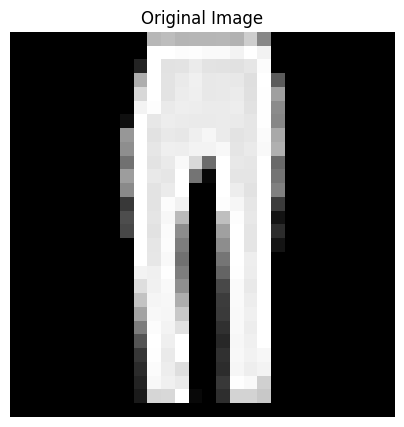

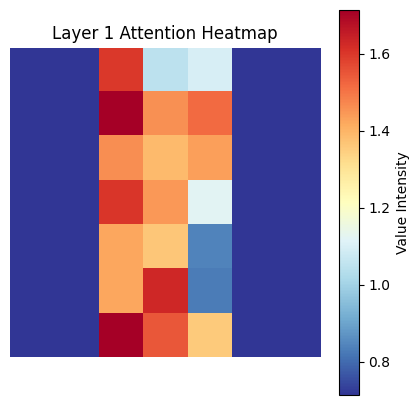

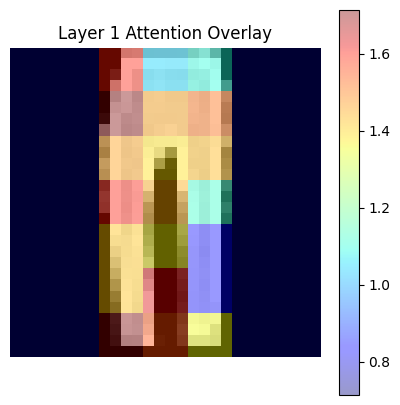

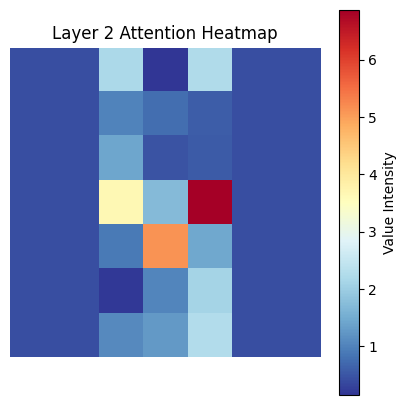

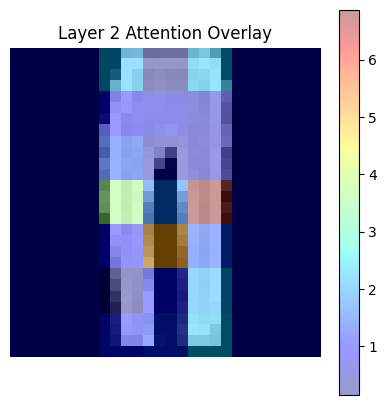

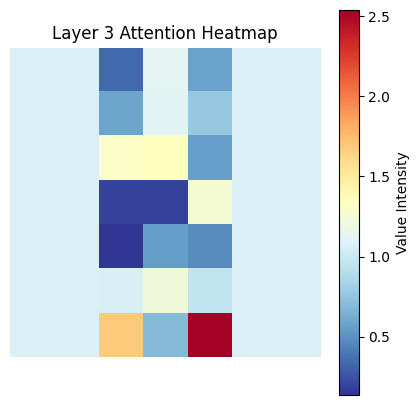

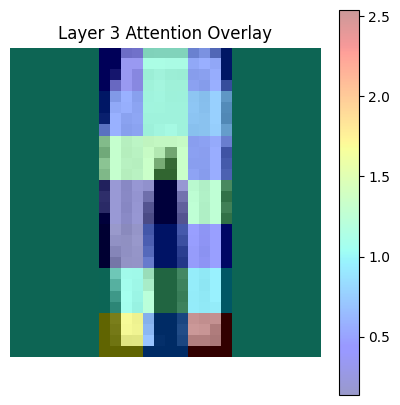

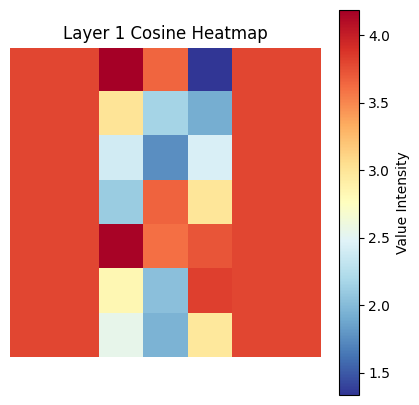

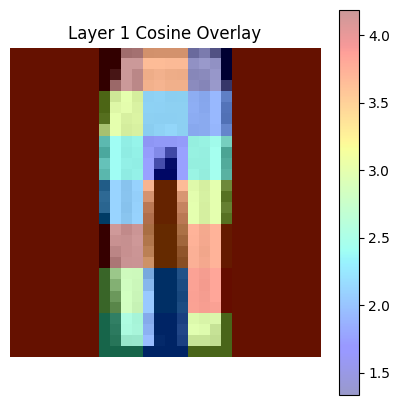

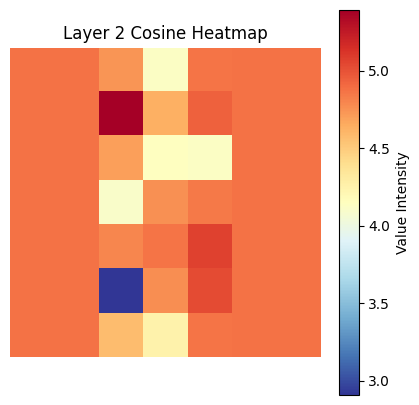

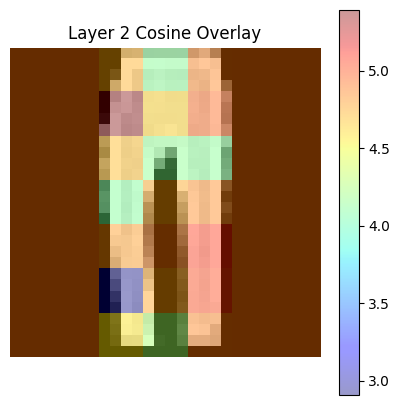

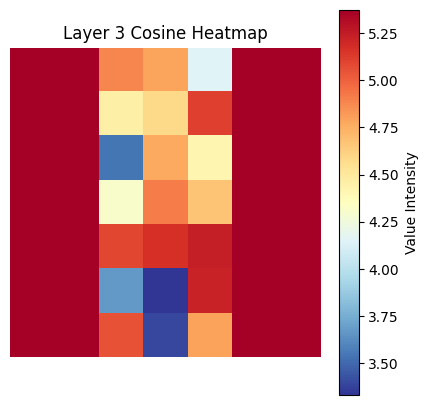

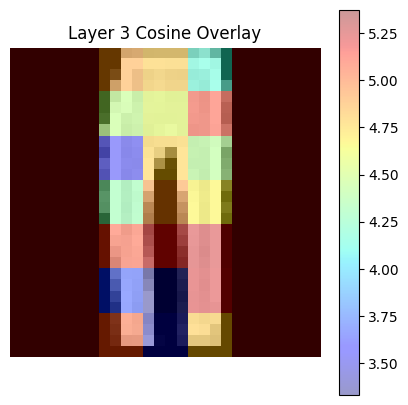

In [9]:
# One-cell runner: configure model + dataset, then show layerwise attention/cosine heatmaps (no saving)
import os
import sys
import importlib
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# ---- Config ----
PROJECT_ROOT = "/home/junyeollee/QSANN/codes/QSANN_revision"
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

MODEL_MODULE = "model"  # or 'model_revision'
CHECKPOINT_PATH = "/home/junyeollee/QSANN/codes/QSANN_revision/results/models/grid-fmnist-img28-mmodel-v1-r2-al3-hd__none___best.pt"

DATASET_CHOICE = "fmnist"  # 'mnist' | 'fmnist' | 'cifar10'
DATA_ROOT = "/home/junyeollee/QSANN/codes/QSANN_revision/data"
TARGET_LABELS = [0, 1]  # only pick from these classes
SAMPLE_INDEX = 11  # index within the filtered subset

IMAGE_SIZE = 28
PATCH_SIZE = 4
NUM_QUBITS = 8
VQC_LAYERS = 1
REUPLOADING = 2
MEASUREMENT = "correlations"  # or 'statevector'
BACKEND_DEVICE = "gpu"  # or 'cpu'
USE_TORCH_AUTOGRAD = True

QKV_MODE = "separate"  # 'shared' or 'separate'
QKV_DIM = 64
ATTN_LAYERS = 3
ATTN_TYPE = "rbf"  # 'dot' or 'rbf'
RBF_GAMMA = 1.0
AGG_MODE = "concat"  # 'concat' | 'gap_gmp' | 'attn_pool'
HIDDEN_DIMS = []  # e.g., [64], or [] for none
DROPOUT = 0.3
NUM_CLASSES = 10

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

# ---- Load sample ----
if DATASET_CHOICE in ("mnist", "fmnist"):
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
    ])
    if DATASET_CHOICE == "mnist":
        ds = datasets.MNIST(root=DATA_ROOT, train=False, download=False, transform=transform)
    else:
        ds = datasets.FashionMNIST(root=DATA_ROOT, train=False, download=False, transform=transform)
    labels = [int(y) for _, y in ds]
    indices = [i for i, y in enumerate(labels) if y in TARGET_LABELS]
    if not indices:
        raise RuntimeError("No samples found for TARGET_LABELS.")
    idx = indices[SAMPLE_INDEX % len(indices)]
    img, label = ds[idx]
    sample_tensor = img.unsqueeze(0)  # [1, 1, H, W]
    print("picked label:", label, "raw index:", idx)
elif DATASET_CHOICE == "cifar10":
    CIFAR_GRAYSCALE = False  # set True to match grayscale training
    if CIFAR_GRAYSCALE:
        transform = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor(),
        ])
    ds = datasets.CIFAR10(root=DATA_ROOT, train=False, download=False, transform=transform)
    labels = [int(y) for _, y in ds]
    indices = [i for i, y in enumerate(labels) if y in TARGET_LABELS]
    if not indices:
        raise RuntimeError("No samples found for TARGET_LABELS.")
    idx = indices[SAMPLE_INDEX % len(indices)]
    img, label = ds[idx]
    sample_tensor = img.unsqueeze(0)  # [1, C, H, W]
    print("picked label:", label, "raw index:", idx)
else:
    raise ValueError("DATASET_CHOICE must be 'mnist', 'fmnist', or 'cifar10'.")

# ---- Build model ----
if isinstance(PATCH_SIZE, (tuple, list)):
    patch_h, patch_w = int(PATCH_SIZE[0]), int(PATCH_SIZE[1])
else:
    patch_h = patch_w = int(PATCH_SIZE)
if IMAGE_SIZE % patch_h != 0 or IMAGE_SIZE % patch_w != 0:
    raise ValueError("IMAGE_SIZE must be divisible by PATCH_SIZE.")

channels = int(sample_tensor.shape[1])
data_dim = channels * patch_h * patch_w

mod = importlib.import_module(MODEL_MODULE)
QuantumAnsatz = getattr(mod, "QuantumAnsatz")
HybridQuantumClassifier = getattr(mod, "HybridQuantumClassifier")

ansatz = QuantumAnsatz(
    data_dim=data_dim,
    num_qubits=NUM_QUBITS,
    vqc_layers=VQC_LAYERS,
    reuploading=REUPLOADING,
    measurement=MEASUREMENT,
    backend_device=BACKEND_DEVICE,
    use_torch_autograd=USE_TORCH_AUTOGRAD,
)

if QKV_MODE == "shared":
    model = HybridQuantumClassifier(
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        ansatz=ansatz,
        q_dim=QKV_DIM,
        k_dim=QKV_DIM,
        v_dim=QKV_DIM,
        attn_layers=ATTN_LAYERS,
        attn_type=ATTN_TYPE,
        rbf_gamma=RBF_GAMMA,
        agg_mode=AGG_MODE,
        hidden_dims=HIDDEN_DIMS,
        dropout=DROPOUT,
        device=DEVICE,
        qkv_mode=QKV_MODE,
        num_classes=NUM_CLASSES,
    )
else:
    ansatz_k = QuantumAnsatz(
        data_dim=data_dim,
        num_qubits=NUM_QUBITS,
        vqc_layers=VQC_LAYERS,
        reuploading=REUPLOADING,
        measurement=MEASUREMENT,
        backend_device=BACKEND_DEVICE,
        use_torch_autograd=USE_TORCH_AUTOGRAD,
    )
    ansatz_v = QuantumAnsatz(
        data_dim=data_dim,
        num_qubits=NUM_QUBITS,
        vqc_layers=VQC_LAYERS,
        reuploading=REUPLOADING,
        measurement=MEASUREMENT,
        backend_device=BACKEND_DEVICE,
        use_torch_autograd=USE_TORCH_AUTOGRAD,
    )
    model = HybridQuantumClassifier(
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        ansatz=ansatz,
        ansatz_k=ansatz_k,
        ansatz_v=ansatz_v,
        q_dim=QKV_DIM,
        k_dim=QKV_DIM,
        v_dim=QKV_DIM,
        attn_layers=ATTN_LAYERS,
        attn_type=ATTN_TYPE,
        rbf_gamma=RBF_GAMMA,
        agg_mode=AGG_MODE,
        hidden_dims=HIDDEN_DIMS,
        dropout=DROPOUT,
        device=DEVICE,
        qkv_mode=QKV_MODE,
        num_classes=NUM_CLASSES,
    )

ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
state_dict = ckpt.get("state_dict") or ckpt.get("model_state_dict") or ckpt if isinstance(ckpt, dict) else ckpt
model.load_state_dict(state_dict, strict=True)
model.eval()

# ---- Inference ----
sample_tensor = sample_tensor.to(DEVICE)
with torch.no_grad():
    logits, attn_stats, weights_list, intermediates = model(
        sample_tensor, return_attention=True, return_intermediates=True
    )

# ---- Helpers ----
def attention_heatmap(weights: torch.Tensor) -> np.ndarray:
    heat = weights.sum(dim=0).cpu().numpy()
    return heat.reshape(patch_rows, patch_cols)

def cosine_score(intermediate: dict, use_output: bool = False) -> np.ndarray:
    y1 = intermediate["input"][0]
    y2 = intermediate["output"][0] if use_output else intermediate["residual"][0]
    eps = 1e-12
    length_ratio = y2.norm(dim=-1) / (y1.norm(dim=-1) + eps)
    cos_sim = F.cosine_similarity(y1, y2, dim=-1)
    score = length_ratio * torch.exp(cos_sim)
    return score.cpu().numpy().reshape(patch_rows, patch_cols)

def show_heatmap_and_overlay(base: np.ndarray, heatmap: np.ndarray, title_prefix: str) -> None:
    # heatmap only
    plt.figure(figsize=(5, 5))
    plt.imshow(heatmap, cmap='RdYlBu_r', interpolation='nearest')
    plt.colorbar(label='Value Intensity')
    plt.title(f"{title_prefix} Heatmap")
    plt.axis('off')
    plt.show()

    # overlay
    heat_up = np.kron(heatmap, np.ones((patch_h, patch_w)))
    plt.figure(figsize=(5, 5))
    if base.ndim == 2:
        plt.imshow(base, cmap='gray', interpolation='none')
    else:
        plt.imshow(base, interpolation='none')
    plt.imshow(heat_up, cmap='jet', alpha=0.4, interpolation='none')
    plt.colorbar()
    plt.title(f"{title_prefix} Overlay")
    plt.axis('off')
    plt.show()

# ---- Display ----
patch_rows = IMAGE_SIZE // patch_h
patch_cols = IMAGE_SIZE // patch_w

img = sample_tensor[0].detach().cpu()
if img.shape[0] == 1:
    base_img = img[0].numpy()
else:
    base_img = img.permute(1, 2, 0).numpy()
base_img = np.clip(base_img, 0.0, 1.0)

plt.figure(figsize=(5, 5))
if base_img.ndim == 2:
    plt.imshow(base_img, cmap='gray', interpolation='none')
else:
    plt.imshow(base_img, interpolation='none')
plt.title('Original Image')
plt.axis('off')
plt.show()

for i, weights in enumerate(weights_list):
    attn_map = attention_heatmap(weights[0])
    show_heatmap_and_overlay(base_img, attn_map, f"Layer {i+1} Attention")

for i, inter in enumerate(intermediates):
    cos_map = cosine_score(inter, use_output=False)
    show_heatmap_and_overlay(base_img, cos_map, f"Layer {i+1} Cosine")
